## Imports

### Import Libraries

This script includes TensorFlow for deep learning, NumPy for numerical operations, Matplotlib for data visualisation, and Keras-specific components for working with pre-trained models and image processing.

In [1]:
# import numpy, tensorflow and matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time

# import VGG 19 model and keras Model API
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

## Import Image Data

Now, we import the content and style images and save them into our working directory.

In [2]:
# Image Credits: Tensorflow Doc
content_path = tf.keras.utils.get_file(
  'content.jpg',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file(
  'style.jpg',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

195196/195196 [==============================] - 0s 1us/step


## Image Processing

Now, we load and process the image using Keras preprocess input in VGG 19. The `expand_dims` function adds a dimension to represent a number of images in the input.

This `preprocess_input` function (used in VGG 19) converts the input RGB to BGR images and centre these values around 0 according to ImageNet data (no scaling).

In [3]:
def load_and_process_image(image_path):
    img = load_img(image_path)
    # convert image to array
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img

Now, we define the `deprocess` function that takes the input image and perform the inverse of `preprocess_input` function that we imported above. To display the unprocessed image, we also define a display function.

In [4]:
def deprocess(img):
    # perform the inverse of the pre processing step
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # convert RGB to BGR
    img = img[:, :, ::-1]

    img = np.clip(img, 0, 255).astype('uint8')
    return img


def display_image(image):
    # remove one dimension if image has 4 dimension
    if len(image.shape) == 4:
        img = np.squeeze(image, axis=0)

    img = deprocess(img)

    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return

Now, we use the above function to display the style and content images

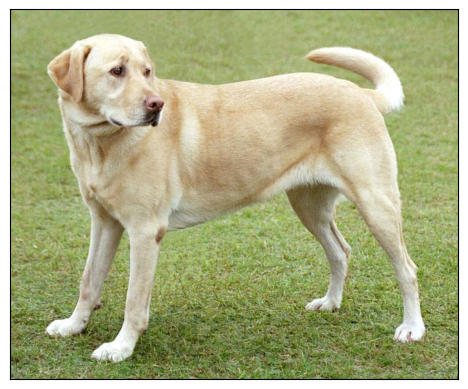

In [5]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)

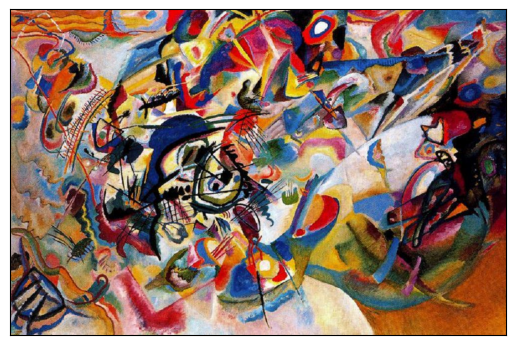

In [6]:
# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)

## Model Initialization

### VGG Model

Now, we initialize the VGG model with ImageNet weights, we will also remove the top layers and make it non-trainable.

In [7]:
# this function download the VGG model and initialize it
model = VGG19(
    include_top=False,
    weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers

model.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

### Content Model

Now, we define the content and style model using Keras.Model API. The content model takes the image as input and output the feature map from `'block5_conv1'` from the above VGG model.

In [8]:
# define content model
content_layer = 'block5_conv2'
content_model = Model(
    inputs=model.input,
    outputs=model.get_layer(content_layer).output
)
content_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Style Model

Now, we define the content and style model using Keras.Model API. The style model takes an image as input and output the feature map from `'block1_conv1'`, `'block3_conv1'`, and `'block5_conv2'`″ from the above VGG model

In [9]:
# define style model
style_layers = [
    'block1_conv1',
    'block3_conv1',
    'block5_conv1'
]
style_models = [Model(inputs=model.input,
                      outputs=model.get_layer(layer).output) for layer in style_layers]

## Loss

### Gram Matrix

Now, we define the gram matrix function. This function also takes the real and generated images as the input of the model and calculates gram matrices of them before calculate the style loss weighted to different layers.

In [10]:
# gram matrix
def gram_matrix(A):
    channels = int(A.shape[-1])
    a = tf.reshape(A, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)

### Style Loss

The function `style_cost`, defined by this code, determines the style loss between a generated image and a style image that is supplied. In neural style transfer algorithms, style loss is frequently employed to create an image that blends the content of two different images with their styles.

In [11]:
 #style loss
def style_cost(style, generated):
    J_style = 0

    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        content_cost = tf.reduce_mean(tf.square(GS - GG))
        J_style += content_cost * weight_of_layer

    return J_style

### Content Loss

The content loss between a style image and a generated image is determined by the function `content_cost`, which is defined in this code. To make sure that the generated image preserves the original image’s content, neural style transfer algorithms frequently employ content loss.

In [12]:
#content loss
def content_cost(style, generated):
    J_content = 0

    for style_model in style_models:
        a_S = style_model(style)
        a_G = style_model(generated)
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)
        content_cost = tf.reduce_mean(tf.square(GS - GG))
        J_content += content_cost * weight_of_layer

    return J_content

## Training

### Training Function

Now, we define our training function, we will train our model to 50 iterations. This model takes input images, the number of iterations as its argument.

In [13]:
# training function
generated_images = []

def training(content_path, style_path, iterations=50, a=10, b=100):
    # Load content and style images from their respective paths
    content = load_and_process_image(content_path)
    style = load_and_process_image(style_path)
    generated = tf.Variable(content, dtype=tf.float32)

    opt = tf.keras.optimizers.Adam(learning_rate=7)

    best_cost = math.inf
    best_image = None

    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content = content_cost(content, generated)
            J_style = style_cost(style, generated)
            J_total = a * J_content + b * J_style

        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])

        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()

        print("Iteration: {}".format(i))
        print("Total Loss: {:.6e}".format(J_total))
        generated_images.append(generated.numpy())

    return best_image

### Model Training

Now, we train our model using the training function we defined above.

✔ **TRY** -- setting the iterations to 5, 25, and 50 and compare the results

In [14]:
# Train the model and get best image
import time
start=time.time()
final_img = training(content_path, style_path, iterations=10)
end=time.time()
print('Execution time:', end-start, 'seconds')

Iteration: 0
Total Loss: 4.536870e+10
Iteration: 1
Total Loss: 3.114796e+10
Iteration: 2
Total Loss: 2.003215e+10
Iteration: 3
Total Loss: 1.788931e+10
Iteration: 4
Total Loss: 1.637648e+10
Iteration: 5
Total Loss: 1.310667e+10
Iteration: 6
Total Loss: 1.084884e+10
Iteration: 7
Total Loss: 9.697794e+09
Iteration: 8
Total Loss: 8.944771e+09
Iteration: 9
Total Loss: 8.324450e+09
Execution time: 35.67089796066284 seconds


## Model Prediction

In the final step, we plot the final and intermediate results.

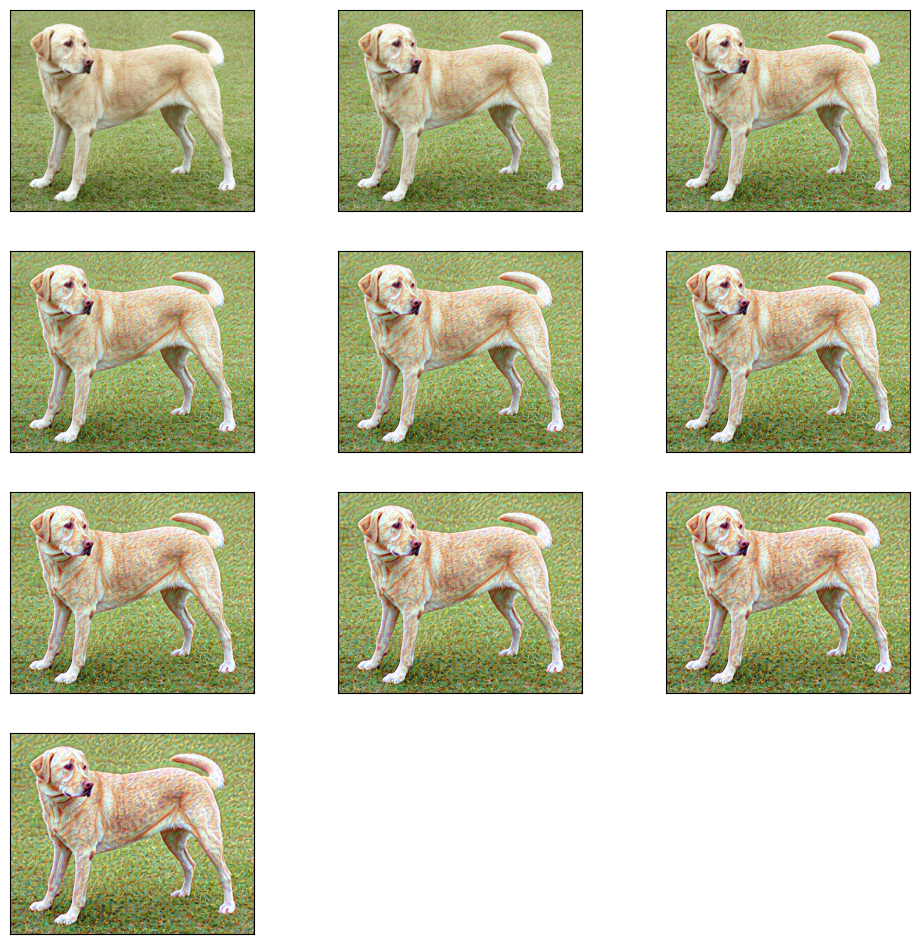

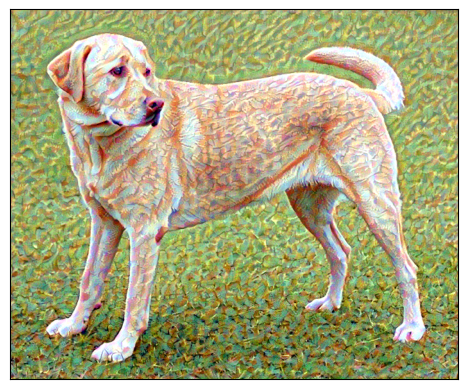

In [15]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))

for i in range(len(generated_images)):
    plt.subplot(4, 3, i + 1)
    display_image(generated_images[i])
plt.show()

# plot best result
display_image(final_img)

In [16]:
len(generated_images)

10